#Download Files

In [ ]:
# Download data

!gdown --id 1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp

Downloading...
From: https://drive.google.com/uc?id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp
To: /content/lfwa.zip
104MB [00:00, 136MB/s] 


In [ ]:
# Unzip data

!unzip lfwa.zip -d data

In [ ]:
# Download train and test

!gdown http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
!gdown http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt

Downloading...
From: http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
To: /content/pairsDevTest.txt
100% 26.0k/26.0k [00:00<00:00, 824kB/s]
Downloading...
From: http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
To: /content/pairsDevTrain.txt
100% 56.6k/56.6k [00:00<00:00, 894kB/s]


#Preprocessing

In [ ]:
# People amount
import os

data_path = "data/lfw2/lfw2"
people_list = os.listdir(data_path)
people_count = len(people_list)
print(f"There are {people_count} people's images in the dataset")

There are 5749 people's images in the dataset


In [ ]:
train_file_path = "pairsDevTrain.txt"
test_file_path = "pairsDevTest.txt"
data_path = "data/lfw2/lfw2"

In [ ]:
# create data list
import pandas as pd
import random

def load_txt_file_data(txt_file_path, create_validation=False):
  """
  """

  data = open(txt_file_path).read()
  data_list = data.split('\n')
  last_same_pairs_ind = int(data_list[0]) + 1
  

  same_pairs_list = data_list[1:last_same_pairs_ind]
  different_pairs_list = data_list[last_same_pairs_ind:]

  # create a list of tuples with (1st person name, 1st person pic number,
  # 2nd person name, 2nd person pic number, label) when label is 0 for different
  # and 1 for same
  same_list = []
  different_list = []
  

  # process same pairs
  for pair in same_pairs_list:
    pair_data = pair.split('\t')
    name = pair_data[0]
    first_img = pair_data[1]
    second_img = pair_data[2]
    label = 1
    pair_tuple = (name, first_img, name, second_img, 1)
    same_list.append(pair_tuple)

  # process different pairs
  for pair in different_pairs_list:
    if pair == "":
      continue
    pair_data = pair.split('\t')
    first_name = pair_data[0]
    first_img = pair_data[1]
    second_name = pair_data[2]
    second_img = pair_data[3]
    label = 0
    pair_tuple = (first_name, first_img, second_name, second_img, 0)
    different_list.append(pair_tuple)

  if create_validation:
    # get 10% of the data equally from same and different pairs for the validation
    # set
    val_ratio = 0.1
    val_per_list_size = int(0.1 * len(same_list))

    val_list = same_list[:val_per_list_size] + different_list[:val_per_list_size]

    data_list = same_list[val_per_list_size:] + different_list[val_per_list_size:]

    # shuffle the lists
    random.shuffle(data_list)
    random.shuffle(val_list)

    return data_list, val_list
  
  # if not creating validation set
  data_list = same_list + different_list
  random.shuffle(data_list)
  return data_list

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

def get_image_path(name, pic_num, data_path = data_path):
  dir_path = os.path.join(data_path, name)
  dir_files = os.listdir(dir_path)

  for file_name in dir_files:
    if file_name.endswith(f"{pic_num}.jpg"):
      file_path = os.path.join(os.path.join(data_path, name), file_name)
      return file_path
  

def get_pairs_pics_label(data_list):
  """
  gets a data list of tuples and returns two pictures in gray scale and
  their label - 0 for different and 1 for same
  """
  
  res_list = []

  for pair in data_list:
    first_name, first_pic_num, second_name, second_pic_num, label = pair
    
    first_img_path = get_image_path(first_name, first_pic_num)
    second_img_path = get_image_path(second_name, second_pic_num)

    # img_size=(105,105)
    first_img = load_img(path = first_img_path, color_mode = 'grayscale')
    first_img = img_to_array(first_img)
    first_img = tf.image.central_crop(first_img, 0.5)
    # first_img = first_img / 255.0
    second_img = load_img(path = second_img_path, color_mode = 'grayscale')
    second_img = img_to_array(second_img)
    second_img = tf.image.central_crop(second_img, 0.5)
    # second_img = second_img / 255.0

    pair_data = (first_img, second_img, label)
    res_list.append(pair_data)



  
  return res_list

In [ ]:
def get_x_y(data):
  """
  gets a data list of tuples (image, image, label) and returns an np.array
  of [left_input, right input] and an np.array of y labels
  """

  X1_list = []
  X2_list = []
  y_list = []
  for sample in data:
    first_img, second_img, label = sample
    X1_list.append(first_img)
    X2_list.append(second_img)
    y_list.append(label)
  
  return X1_list, X2_list, y_list

#Build Model

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Lambda, Input, Flatten, Dense, Concatenate, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from scipy.spatial.distance import cosine
from numpy.linalg import norm

def l1_dist(vect):
    x, y = vect
    return abs(x-y)

def l2_dist(vect):
    x, y = vect
    return (x-y)*(x-y)


def get_model(with_batch_normalization=False, distance_func = 'l1', input_shape= (105,105,1)):
  W_init_1 = RandomNormal(mean=0, stddev=0.01)
  b_init = RandomNormal(mean=0.5, stddev = 0.01)
  W_init_2 = RandomNormal(mean=0, stddev=0.2)

  # input_shape = (105, 105, 1)
  left_input = Input(input_shape)
  right_input = Input(input_shape)

  convnet = Sequential()
  # convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape, kernel_initializer=W_init_1, bias_initializer = b_init ,kernel_regularizer=l2(2e-4)))
  convnet.add(Conv2D(64,(10,10),activation='relu'))
  if with_batch_normalization:
    convnet.add(BatchNormalization())
  convnet.add(MaxPooling2D())
  # convnet.add(Dropout(0.5))
  # convnet.add(Conv2D(128,(7,7),activation='relu', kernel_initializer=W_init_1, bias_initializer = b_init ,kernel_regularizer=l2(0.05)))
  convnet.add(Conv2D(128,(7,7),activation='relu'))
  if with_batch_normalization:
    convnet.add(BatchNormalization())
  convnet.add(MaxPooling2D())
  # convnet.add(Dropout(0.5))
  # convnet.add(Conv2D(128,(4,4),activation='relu', kernel_initializer=W_init_1, bias_initializer = b_init ,kernel_regularizer=l2(0.05)))
  convnet.add(Conv2D(128,(4,4),activation='relu'))
  if with_batch_normalization:
    convnet.add(BatchNormalization())
  convnet.add(MaxPooling2D())
  # convnet.add(Dropout(0.5))
  # convnet.add(Conv2D(256,(4,4),activation='relu', kernel_initializer=W_init_1, bias_initializer = b_init ,kernel_regularizer=l2(0.05)))
  convnet.add(Conv2D(256,(4,4),activation='relu'))
  if with_batch_normalization:
    convnet.add(BatchNormalization())
  convnet.add(Flatten())
  # convnet.add(Dense(4096,activation="sigmoid", kernel_initializer=W_init_2, bias_initializer = b_init ,kernel_regularizer=l2(0.05)))
  convnet.add(Dense(4096,activation="sigmoid"))
  encoded_l = convnet(left_input)
  encoded_r = convnet(right_input)

  if distance_func=='l1':
    merge_layer = Lambda(l1_dist)([encoded_l,encoded_r])
  elif distance_func=='l2':
    merge_layer = Lambda(l2_dist)([encoded_l,encoded_r])

  prediction = Dense(1,activation='sigmoid')(merge_layer)
  model = Model(inputs=[left_input,right_input],outputs=prediction)

  
  # model.compile(loss = 'binary_crossentropy', optimizer = SGD(lr = 0.0001, momentum = 0.5), metrics = ['accuracy'])
  model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['accuracy'])

  return model


#Model L1 Distance

## Get Data

In [ ]:
import numpy as np

train_meta_data, val_meta_data = load_txt_file_data(train_file_path, create_validation = True)

# process train data
train_data = get_pairs_pics_label(train_meta_data)

X1_train, X2_train, y_train = get_x_y(train_data)

# add to the train set flipped one picture
X1_train_flip, X2_train_flip, y_train_flip = get_x_y(train_data)
for i in range(len(X1_train_flip)):
  X1_train_flip[i] = tf.image.flip_left_right(X1_train_flip[i])

# add to the train set flipped one picture
X1_train_flip_up, X2_train_flip_up, y_train_flip_up = get_x_y(train_data)
for i in range(len(X1_train_flip)):
  # X1_train_flip_up[i] = tf.image.flip_up_down(X1_train_flip_up[i])
  # X2_train_flip_up[i] = tf.image.flip_up_down(X2_train_flip_up[i])
  X2_train_flip_up[i] = tf.image.flip_left_right(X2_train_flip_up[i])

  

# # add to the train set samples with random brithness change
# X1_train_brightness, X2_train_brightness, y_train_brightness = get_x_y(train_data)
# for i in range(len(X1_train_brightness)):
#   X1_train_brightness[i] = X1_train_brightness[i] * 10000

# create the train set
X_train = [np.asarray(X1_train + X1_train_flip + X1_train_flip_up), np.asarray(X2_train + X2_train_flip + X2_train_flip_up)]
# X_train = [np.asarray(X1_train + X1_train_flip), np.asarray(X2_train + X2_train_flip)]
y_train = y_train + y_train_flip + y_train_flip_up
# y_train = y_train + y_train_flip

# process validation data
val_data = get_pairs_pics_label(val_meta_data)
X1_val, X2_val, y_val = get_x_y(val_data)
X_val = [np.asarray(X1_val), np.asarray(X2_val)]



## Get Model

In [ ]:
model_l1_dist = get_model(with_batch_normalization = True, distance_func='l1', input_shape = X_train[0][0].shape)
model_l1_dist.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 126, 126, 1) 0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 126, 126, 1) 0                                            
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 4096)         68310080    input_31[0][0]                   
                                                                 input_32[0][0]                   
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 4096)         0           sequential_15[0][0]       

## Model Training with l1 distance

In [ ]:
# run fit with gpu
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# add early stopping callback
earlistopping_callback = EarlyStopping(monitor='val_loss', patience=4)


with tf.device('/device:GPU:0'):
  history = model_l1_dist.fit(x= X_train, y= np.asarray(y_train).astype(np.float32), batch_size=16, epochs= 200, validation_data = (X_val, np.asarray(y_val)),
                      callbacks=[earlistopping_callback] )

Epoch 1/200
372/372 [==============================] - 29s 74ms/step - loss: 0.5973 - accuracy: 0.6614 - val_loss: 0.5005 - val_accuracy: 0.7636
Epoch 2/200
372/372 [==============================] - 27s 73ms/step - loss: 0.1505 - accuracy: 0.9617 - val_loss: 0.5099 - val_accuracy: 0.7545
Epoch 3/200
372/372 [==============================] - 27s 73ms/step - loss: 0.0240 - accuracy: 0.9980 - val_loss: 0.4477 - val_accuracy: 0.7955
Epoch 4/200
372/372 [==============================] - 27s 73ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.4443 - val_accuracy: 0.8136
Epoch 5/200
372/372 [==============================] - 27s 73ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.4517 - val_accuracy: 0.8182
Epoch 6/200
372/372 [==============================] - 27s 73ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4576 - val_accuracy: 0.8091
Epoch 7/200
372/372 [==============================] - 27s 73ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4584 - val_ac

##Test Model

###Get Test Data

In [ ]:
# Test data
test_meta_data = load_txt_file_data(test_file_path)
test_data = get_pairs_pics_label(test_meta_data)
X1_test, X2_test, y_test = get_x_y(test_data)
X_test = [np.asarray(X1_test), np.asarray(X2_test)]

###Get Predictions

In [ ]:
# Test accuracy
with tf.device('/device:GPU:0'):
  pred = model_l1_dist.predict(X_test)

###Plot Learning

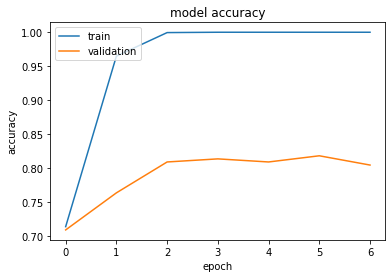

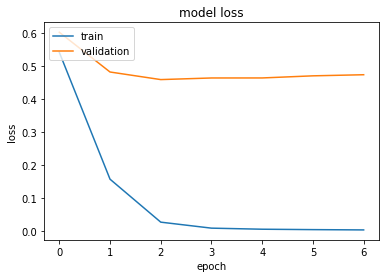

In [ ]:
import matplotlib.pyplot as plt



#  Train and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print()

# Train and validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Test Results

In [ ]:
from sklearn.metrics import f1_score, classification_report

# Values binarization 
pred = np.where(pred > 0.5, 1, 0)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       500
           1       0.76      0.79      0.78       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



# Model L2 Distance

## Get Data

In [ ]:
train_meta_data, val_meta_data = load_txt_file_data(train_file_path, create_validation = True)

# process train data
train_data = get_pairs_pics_label(train_meta_data)
X1_train, X2_train, y_train = get_x_y(train_data)
X_train = [np.asarray(X1_train), np.asarray(X2_train)]

# process validation data
val_data = get_pairs_pics_label(val_meta_data)
X1_val, X2_val, y_val = get_x_y(val_data)
X_val = [np.asarray(X1_val), np.asarray(X2_val)]



##Get Model

In [ ]:
model_l2_dist = get_model(with_batch_normalization = False, distance_func='l2')
model.summary()

NameError: ignored

##Model Training with l2 distance

In [ ]:
# run fit with gpu
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# add early stopping callback
earlistopping_callback = EarlyStopping(monitor='val_loss', patience=20)


with tf.device('/device:GPU:0'):
  history = model_l2_dist.fit(x= X_train, y= np.asarray(y_train).astype(np.float32), batch_size=32, epochs= 200, validation_data = (X_val, np.asarray(y_val)),
                      callbacks=[earlistopping_callback] )

##Test Model

###Get Test Data

In [ ]:
# Test data
test_meta_data = load_txt_file_data(test_file_path)
test_data = get_pairs_pics_label(test_meta_data)
X1_test, X2_test, y_test = get_x_y(test_data)
X_test = [np.asarray(X1_test), np.asarray(X2_test)]


###Get Predictions

In [ ]:
# Test accuracy
with tf.device('/device:GPU:0'):
  pred = model_l2_dist.predict(X_test)

### Plot Learning

In [ ]:
import matplotlib.pyplot as plt



#  Train and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print()

# Train and validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Test Results

In [ ]:
from sklearn.metrics import f1_score, classification_report

# Values binarization 
pred = np.where(pred > 0.5, 1, 0)

print(classification_report(y_test, pred))

#ImageNet Based Model

In [ ]:
def get_pairs_pics_label_3_channels(data_list):
  """
  gets a data list of tuples and returns two pictures in gray scale and
  their label - 0 for different and 1 for same
  """
  
  res_list = []

  for pair in data_list:
    first_name, first_pic_num, second_name, second_pic_num, label = pair
    
    first_img_path = get_image_path(first_name, first_pic_num)
    second_img_path = get_image_path(second_name, second_pic_num)

    img_size=(105,105)
    first_img = load_img(path = first_img_path, color_mode = 'grayscale', target_size=img_size)
    first_img = img_to_array(first_img)
    first_img = np.repeat(first_img, 3, 2)
    second_img = load_img(path = second_img_path, color_mode = 'grayscale', target_size=img_size)
    second_img = img_to_array(second_img)
    second_img = np.repeat(second_img, 3, 2)

    pair_data = (first_img, second_img, label)
    res_list.append(pair_data)
  
  return res_list






In [ ]:
from keras.applications.vgg16 import VGG16

def dist(vect):
    x, y = vect
    return abs(x-y)

def get_imagenet_based_model():
  # Freeze first 10 layers
  VGG = VGG16(include_top=False, input_shape=(105,105,3))
  for layer in VGG.layers[:19]:
    layer.trainable = False

  input_shape = (105, 105, 3)
  left_input = Input(input_shape)
  right_input = Input(input_shape)

  convnet = Sequential()
  convnet.add(VGG)
  convnet.add(Flatten())
  convnet.add(Dense(512, activation='relu', kernel_regularizer=l2(0.05)))

  encoded_l = convnet(left_input)
  encoded_r = convnet(right_input)

  merge_layer = Lambda(dist)([encoded_l,encoded_r])
  prediction = Dense(1,activation='sigmoid')(merge_layer)
  model = Model(inputs=[left_input,right_input],outputs=prediction)

  model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
  model.summary()

  return model

##Get Data

In [ ]:
train_meta_data, val_meta_data = load_txt_file_data(train_file_path, create_validation = True)

# process train data
train_data = get_pairs_pics_label_3_channels(train_meta_data)
X1_train, X2_train, y_train = get_x_y(train_data)
X_train = [np.asarray(X1_train), np.asarray(X2_train)]

# process validation data
val_data = get_pairs_pics_label_3_channels(val_meta_data)
X1_val, X2_val, y_val = get_x_y(val_data)
X_val = [np.asarray(X1_val), np.asarray(X2_val)]

##Get Model

In [ ]:
model_imagenet = get_imagenet_based_model()


##ImageNet Model Training

In [ ]:
# run fit with gpu
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# add early stopping callback
earlistopping_callback = EarlyStopping(monitor='val_loss', patience=20)


with tf.device('/device:GPU:0'):
  history = model_imagenet.fit(x= X_train, y= np.asarray(y_train).astype(np.float32), batch_size=32, epochs= 200, validation_data = (X_val, np.asarray(y_val)),
                      callbacks=[earlistopping_callback] )

##Test Model

###Get Test Data

In [ ]:
# Test data
test_meta_data = load_txt_file_data(test_file_path)
test_data = get_pairs_pics_label_3_channels(test_meta_data)
X1_test, X2_test, y_test = get_x_y(test_data)
X_test = [np.asarray(X1_test), np.asarray(X2_test)]

###Get Predictions

In [ ]:
# Test accuracy
with tf.device('/device:GPU:0'):
  pred = model_imagenet.predict(X_test)

###Plot Learning

In [ ]:
import matplotlib.pyplot as plt



#  Train and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print()

# Train and validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Test Results

In [ ]:
from sklearn.metrics import f1_score, classification_report

# Values binarization 
pred = np.where(pred > 0.5, 1, 0)

print(classification_report(y_test, pred))

#Test Model

In [ ]:
# Test data
test_meta_data = load_txt_file_data(test_file_path)
test_data = get_pairs_pics_label(test_meta_data)
X1_test, X2_test, y_test = get_x_y(test_data)
X_test = [np.asarray(X1_test), np.asarray(X2_test)]






In [ ]:
# Test accuracy
with tf.device('/device:GPU:0'):
  pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score, classification_report

# Values binarization 
pred = np.where(pred > 0.5, 1, 0)
# print(pred.shape)

# print(pred)
print(classification_report(y_test, pred))

In [ ]:
# Test accuracy
with tf.device('/device:GPU:0'):
  pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score, classification_report

# Values binarization 
pred = np.where(pred > 0.5, 1, 0)

print(classification_report(y_test, pred))

# Extra

In [ ]:
test_file_name = "pairsDevTrain.txt"
train_file = open(train_file_name)
train_meta_data = train_file.read()
train_meta_data_list = train_meta_data.split('\n')
print(train_meta_data_list[1100])

Zinedine_Zidane	2	4


In [ ]:
sample = train_meta_data_list[0].split('\t')
name = sample[0]
first_image_ext = sample[1]
second_image_ext = sample[2]
sample_path = os.path.join(data_path, name)
for file_name in os.listdir(sample_path):
  first_image_name = file_name if file_name.endswith(first_image_ext + ".jpg") else first_image_name
  second_image_name = file_name if file_name.endswith(second_image_ext + ".jpg") else second_image_name

first_image_path = os.path.join(sample_path, first_image_path)
second_image_path = os.path.join(sample_path, second_image_path)

print(second_image_name)

Aaron_Peirsol_0002.jpg


In [ ]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         38947648    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_2[0][0]         

In [ ]:
model.train_on_batch

<function fetch_lfw_pairs at 0x7f1049a75a70>


In [ ]:
# Get unzipped data

import os

# d = open("data/lfw2/lfw2", )
data_path = "data/lfw2/lfw2"
os.listdir(data_path)

jpath = os.path.join(data_path, "James_Mathis")
os.listdir(jpath)

['James_Mathis_0001.jpg']

In [ ]:
from sklearn.metrics import f1_score, classification_report

# Values binarization 
pred = np.where(pred > 0.5, 1, 0)
# print(pred.shape)

# print(pred)
print(classification_report(y_test, pred))